In [10]:
import os, re
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv(dotenv_path="untitled.env")

SERVER   = os.getenv("MSSQL_SERVER")
DB       = os.getenv("MSSQL_DATABASE")
USER     = os.getenv("MSSQL_USERNAME")
PWD      = os.getenv("MSSQL_PASSWORD")
DRIVER   = os.getenv("MSSQL_DRIVER", "ODBC Driver 18 for SQL Server")

# SQLAlchemy connection string for SQL Server via ODBC 18
engine = create_engine(
    f"mssql+pyodbc://{USER}:{PWD}@{SERVER}/{DB}"
    f"?driver={DRIVER.replace(' ', '+')}&TrustServerCertificate=yes"
)
# CSV paths (adjust to your file locations)
SALES_CSV = r"Amazon Sale Report.csv"
CLOUD_CSV = r"Cloud Warehouse Compersion Chart.csv"
print("Connected to:", SERVER, " DB:", DB)

Connected to: DESKTOP-5L4E2G3\SQLEXPRESS  DB: vendor_analytics


In [12]:
# Load CSV files into DataFrames
df_sales = pd.read_csv(SALES_CSV)
df_cloud = pd.read_csv(CLOUD_CSV)

print("Sales CSV shape:", df_sales.shape)
print("Cloud CSV shape:", df_cloud.shape)

Sales CSV shape: (128975, 24)
Cloud CSV shape: (50, 4)


C:\Users\hp\AppData\Local\Temp\ipykernel_7980\1211912958.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales = pd.read_csv(SALES_CSV)


In [6]:
def clean_columns(df):
    df.columns = [re.sub(r'\s+', '_', col.strip().lower()) for col in df.columns]
    return df

df_sales = clean_columns(df_sales)
df_cloud = clean_columns(df_cloud)

In [13]:
df_sales.to_sql("sales_data", engine, if_exists="replace", index=False)
df_cloud.to_sql("cloud_comperison", engine, if_exists="replace", index=False)

print("Data ingestion completed successfully!")

Data ingestion completed successfully!


In [8]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT COUNT(*) FROM sales_data"))
    print("Sales Data rows:", result.scalar())

    result = conn.execute(text("SELECT COUNT(*) FROM cloud_comperison"))
    print("Cloud Comperison rows:", result.scalar())

Sales Data rows: 128975
Cloud Comperison rows: 50


In [10]:
# Check data types, missing values, duplicates
print(df_sales.info())
print(df_sales.isnull().sum())
print(df_sales.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   order_id            128975 non-null  object 
 2   date                128975 non-null  object 
 3   status              128975 non-null  object 
 4   fulfilment          128975 non-null  object 
 5   sales_channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   style               128975 non-null  object 
 8   sku                 128975 non-null  object 
 9   category            128975 non-null  object 
 10  size                128975 non-null  object 
 11  asin                128975 non-null  object 
 12  courier_status      122103 non-null  object 
 13  qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  amount              121180 non-nul

In [11]:
print(df_cloud.info())
print(df_cloud.isnull().sum())
print(df_cloud.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       50 non-null     int64 
 1   shiprocket  21 non-null     object
 2   unnamed:_1  41 non-null     object
 3   increff     28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB
None
index          0
shiprocket    29
unnamed:_1     9
increff       22
dtype: int64
0


In [5]:
# -----------------------
# CLEANING SALES DATA
# -----------------------
import numpy as np

# Remove leading/trailing spaces for only string columns
for col in df_sales.select_dtypes(include=["object"]).columns:
    df_sales[col] = df_sales[col].astype(str).str.strip()

# Handle missing values
df_sales = df_sales.replace(["", " ", "  ", "   ", "NA", "NaN", "nan", "N/A", "n/a", "NULL", "null", "None", "-", "--"], np.nan)
df_sales = df_sales.dropna(how="all")  # drop rows completely empty

# Convert date columns safely
if "order_date" in df_sales.columns:
    df_sales["order_date"] = pd.to_datetime(df_sales["order_date"], errors="coerce")

# Remove duplicates
df_sales = df_sales.drop_duplicates()

print("Sales Data cleaned successfully!")

print("--------------------------------------------")
# -----------------------
# CLEANING CLOUD COMPARISON DATA
# -----------------------
for col in df_cloud.select_dtypes(include=["object"]).columns:
    df_cloud[col] = df_cloud[col].astype(str).str.strip()

df_cloud = df_cloud.replace(["", " ", "  ", "   ", "NA", "NaN", "nan", "N/A", "n/a", "NULL", "null", "None", "-", "--"], np.nan)
df_cloud = df_cloud.dropna(how="all")

# Example: Convert numeric columns
numeric_cols = ["cost", "performance_score", "uptime_percentage"]
for col in numeric_cols:
    if col in df_cloud.columns:
        df_cloud[col] = pd.to_numeric(df_cloud[col], errors="coerce")

df_cloud = df_cloud.drop_duplicates()

print("Cloud Comperison Data cleaned successfully!")

Sales Data cleaned successfully!
--------------------------------------------
Cloud Comperison Data cleaned successfully!


In [7]:
# Save cleaned data to SQL Server
df_sales.to_sql("sales_data", engine, if_exists="replace", index=False)
df_cloud.to_sql("cloud_comparison", engine, if_exists="replace", index=False)

print("Cleaned data loaded into SQL Server successfully!")

Cleaned data loaded into SQL Server successfully!


In [19]:
df_sales.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [23]:
df_cloud.head()

,index,Shiprocket,Unnamed: 1,INCREFF
0,0,Heads,Price (Per Unit),Price (Per Unit)
1,1,Inbound (Fresh Stock and RTO),₹4.00,4
2,2,Outbound,₹7.00,11
3,3,Storage Fee/Cft,₹25.00,Rs 0.15/- Per Day
4,4,Customer Return with Detailed QC,₹6.00,15.5


In [25]:
#1. Amazon Sales Dataset — Possible Research Questions & Solutions
#Q1: Which product categories generate the highest total sales?

df_sales.groupby("Category")["Amount"].sum().sort_values(ascending=False)

Category
Set              39204124.03
kurta            21299546.70
Western Dress    11216072.69
Top               5347792.30
Ethnic Dress       791217.66
Blouse             458408.18
Bottom             150667.98
Saree              123933.76
Dupatta               915.00
Name: Amount, dtype: float64

In [43]:
#Q2: Which month has the highest sales volume?
df_sales["Date"] = pd.to_datetime(df_sales["Date"])
df_sales.groupby(df_sales["Date"].dt.to_period("M"))["Amount"].sum().sort_values(ascending=False)

Date
2022-04    28838708.32
2022-05    26226476.75
2022-06    23425809.38
2022-03      101683.85
Freq: M, Name: Amount, dtype: float64

In [35]:
#Q Which cities contribute the most to sales?
city_sales = df_sales.groupby("ship-city")["Amount"].sum().reset_index()
# Sort in descending order
city_sales = city_sales.sort_values(by="Amount", ascending=False)
print(city_sales.head(10))

      ship-city      Amount
776   BENGALURU  6849664.99
2906  HYDERABAD  4946032.82
4795     MUMBAI  3704461.80
5393  NEW DELHI  3613874.78
1466    CHENNAI  3098745.74
6158       PUNE  2338518.18
3712    KOLKATA  1414978.87
2620   GURUGRAM  1221618.74
7587      THANE  1004355.29
4397    LUCKNOW   933926.34


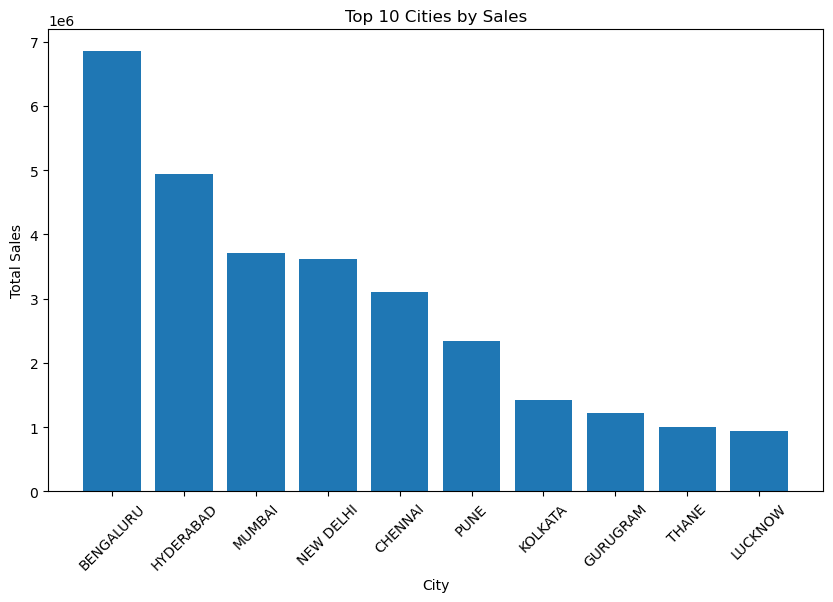

In [47]:
import matplotlib.pyplot as plt

top_cities = city_sales.head(10)

plt.figure(figsize=(10,6))
plt.bar(top_cities["ship-city"], top_cities["Amount"])
plt.title("Top 10 Cities by Sales")
plt.xlabel("City")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_7980\3615129292.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sales["Date"] = pd.to_datetime(df_sales["Date"])


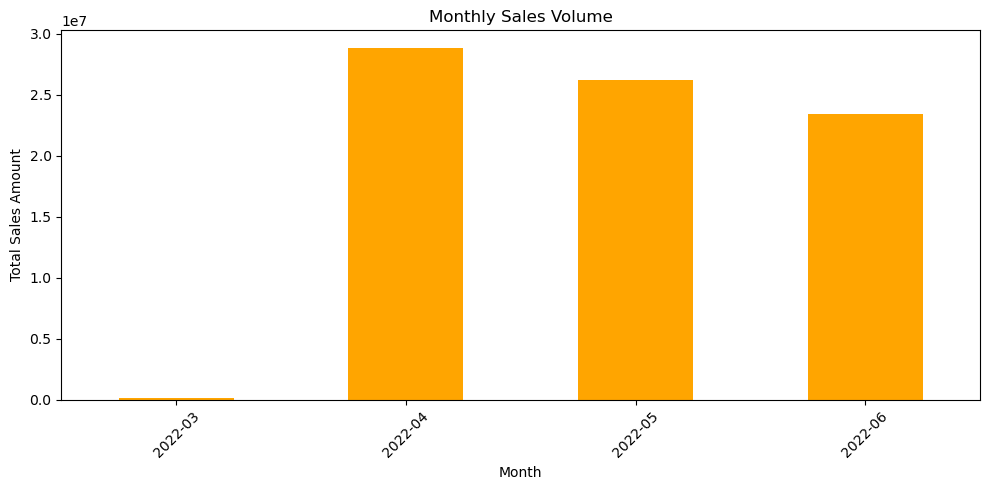

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Date is datetime
df_sales["Date"] = pd.to_datetime(df_sales["Date"])

# Group by month
monthly_sales = df_sales.groupby(df_sales["Date"].dt.to_period("M"))["Amount"].sum()
monthly_sales.index = monthly_sales.index.astype(str)
# Plot
plt.figure(figsize=(10,5))
monthly_sales.plot(kind="bar", color="orange")
plt.title("Monthly Sales Volume")
plt.ylabel("Total Sales Amount")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

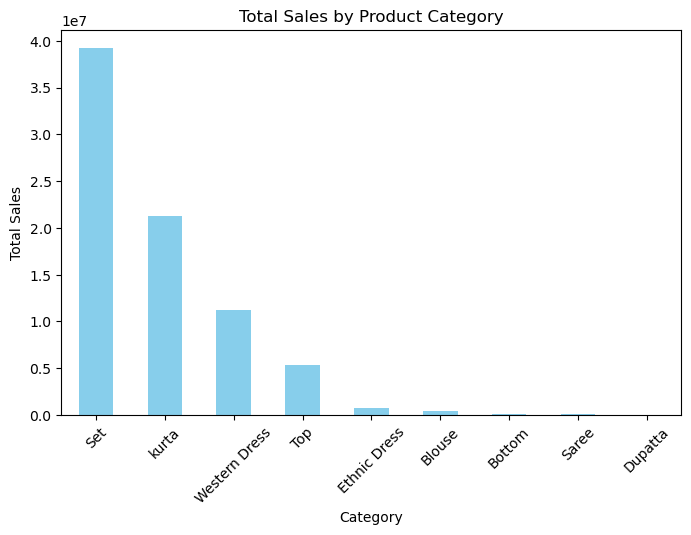

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_sales

# Group by category
category_sales = df.groupby("Category")["Amount"].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,5))
category_sales.plot(kind="bar", color="skyblue")
plt.title("Total Sales by Product Category")
plt.ylabel("Total Sales")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.show()